# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

Импорт библиотек

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

import matplotlib.pyplot as plt  
import seaborn as sns
from sklearn import tree
from sklearn.tree import plot_tree

from tqdm import tqdm

In [2]:
# Открываем файл
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
# Посмотрим на него (широко открытыми глазами)
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
# Посмотрим на типы данных и пропуски
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


**Описание данных**
- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Изменим тип столбца `messages` на int  (сообщения дробными не бывают)

In [5]:
df['messages']=df['messages'].astype("int")

In [6]:
# проверим
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 125.7 KB


In [7]:
# Проверим дубликаты на всякий случай 
df.duplicated().sum()

0

In [8]:
# Описательная статистика
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [9]:
# Проверим на сбалансированность (нулей больше заметно)
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

#### Проверка мультиколлинеарности
Два метода проверки мультиколлинеарности:

- Построение тепловой карты для понимания корреляции

- Использовать коэффициент инфляции дисперсии


In [10]:
# Посмотрим корреляции
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


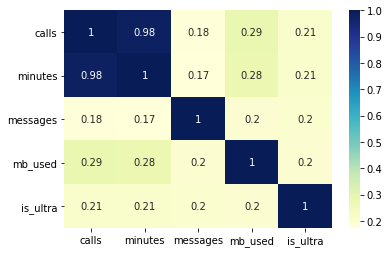

In [11]:
# Построим тепловую карту
df_plot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)  
plt.show()


Cильная корреляция между минутами и звонками, что приводит к мультиколлинеарности.

Проблемы, которые могут возникнуть из-за мультиколлинеарности.

Поскольку существует сильная взаимосвязь, определение значимых переменных будет сложной задачей.

Коэффициенты, которые мы получим для переменных, могут быть нестабильными, и, как следствие, интерпретация модели будет утомительной работой. Может произойти переобучение, и точность модели изменится в зависимости от набора данных.


Коэффициент инфляции дисперсии

Фактор инфляции дисперсии — это мера мультиколлинеарности, которая существует в наборе переменных, участвующих в множественных регрессиях. Как правило, значение vif выше 10 указывает на высокую корреляцию с другими независимыми переменными.

Различные способы решения проблемы Мультиколлинеарности

*Выбор переменных*

Переменные следует выбирать таким образом, чтобы те, которые сильно коррелированы, были удалены, и мы использовали только значимые переменные.

*Преобразование переменных*

Преобразование переменных является неотъемлемым шагом, и здесь цель состоит в том, чтобы сохранить функцию, но выполнение преобразования может дать нам диапазон, который не приведет к предвзятому результату.

*Анализ главных компонентов*

Анализ основных компонентов — это метод уменьшения размерности, с помощью которого мы можем получить важные характеристики набора данных, которые сильно влияют на нашу целевую переменную.

Одна вещь, о которой мы должны позаботиться при реализации PCA, заключается в том, что мы не должны терять основные функции и пытаться уменьшить их таким образом, чтобы собрать максимально возможную информацию.

**Вывод**

- Пропущенных значений не обнаружено

- Типы столбцов немного "причесали"

- Дубликатов нет

- Построена корреляционная матрица и тепловая карта по ней. Заметно коррелируют звонки и минуты, что в целом логично, но приводи к мультиколлинеарности



<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:

👍 Данные изучены.



<div class="alert alert-warning">



Совет: 


- .info (дает тебе информацию о пропусках и типах данных), а .describe (медианы, квантили, max, min итд) это такой джентльменский набор при первичной разведке данных (EDA).  



- Можно еще отдельно проверить датасет на сбалансированность классов в таргете. Это помогло бы решить бонусное задание сразу (Только не надо балансировать данные, это тема следующего проекта).




- Можно посмотреть корреляцию признаков. Знаешь что такое мультиколлинеарность, какие два типа проблем возникает, для каких моделей и какие варианты решения?




</div>


## Разбейте данные на выборки

**Типы выборок**

- features_train, target_train - обучающая выборка
- features_valid, target_valid - валидационная выборка
- features_test, target_test - тестовая выборка

### Разобъем выборки на Тренировочную (80%) и Тестовую (20%)

In [12]:
df_train, df_test = train_test_split(df, test_size=0.4, random_state=123456)
features = df_test.drop('is_ultra', axis=1)
target = df_test['is_ultra']

In [13]:
print(df_train.shape)
print(df_test.shape)

(1928, 5)
(1286, 5)


### Разобъем выборки на валидационную (20%) и тестовую (20%)

In [14]:
features_valid, features_test, target_valid, target_test = train_test_split(features,
target,test_size=0.5, random_state=123456)

In [15]:
features_train = df_train.drop('is_ultra', axis=1)
target_train = df_train['is_ultra']

In [16]:
print(features_train.shape)
print(target_train.shape)

(1928, 4)
(1928,)


In [17]:
df_train.shape, df_test.shape, features_train.shape, target_train.shape

((1928, 5), (1286, 5), (1928, 4), (1928,))

## Исследуйте модели

### Логистическая регрессия

In [18]:
model = LogisticRegression(solver='lbfgs')
model.fit(features_train, target_train)
accuracy_lr = model.score(features_valid, target_valid)
print("Качество:", accuracy_lr)

Качество: 0.7402799377916018


### Случайный лес

In [19]:
best_accuracy_rf = 0
best_depth = 0
accuracies = []
max_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for depth in max_depths:
    for est in tqdm (range(5,50, 5)):
        for sample in range(2,5):
            model_rf = RandomForestClassifier(max_depth=depth, n_estimators=est, 
                                           min_samples_leaf=sample, random_state=123456)
            model_rf.fit(features_train, target_train)
            accuracy_rf = model_rf.score(features_valid, target_valid)
            accuracies.append(accuracy_rf)
            if accuracy_rf > best_accuracy_rf:
                best_accuracy_rf = accuracy_rf
                best_depth = depth
                best_est = est
                best_sample = sample
print("Глубина дерева:", best_depth, "    Количество деревьев:",
      best_est, "   мин. объектов в узле:", best_sample, "  Качество:", best_accuracy_rf)


# print(accuracies)


100%|██████████| 9/9 [00:02<00:00,  3.79it/s]

Глубина дерева: 7     Количество деревьев: 35    мин. объектов в узле: 2   Качество: 0.8180404354587869


In [20]:
# for est in tqdm (range(5,50)):
# Глубина дерева: 7     Количество деревьев: 31    мин. объектов в узле: 2   Качество: 0.8180404354587869


In [21]:
#Попытка показать точность в зависимости от глубины. Неуспешно
#plt.plot(max_depths, accuracies)
#plt.xlabel('Max Depth')
#plt.ylabel('Accuracy')
#plt.title('Random Forest Accuracy vs Max Depth')
#plt.show()

Построим первое дерево решений из случайного леса (с индексом 0 в списке):

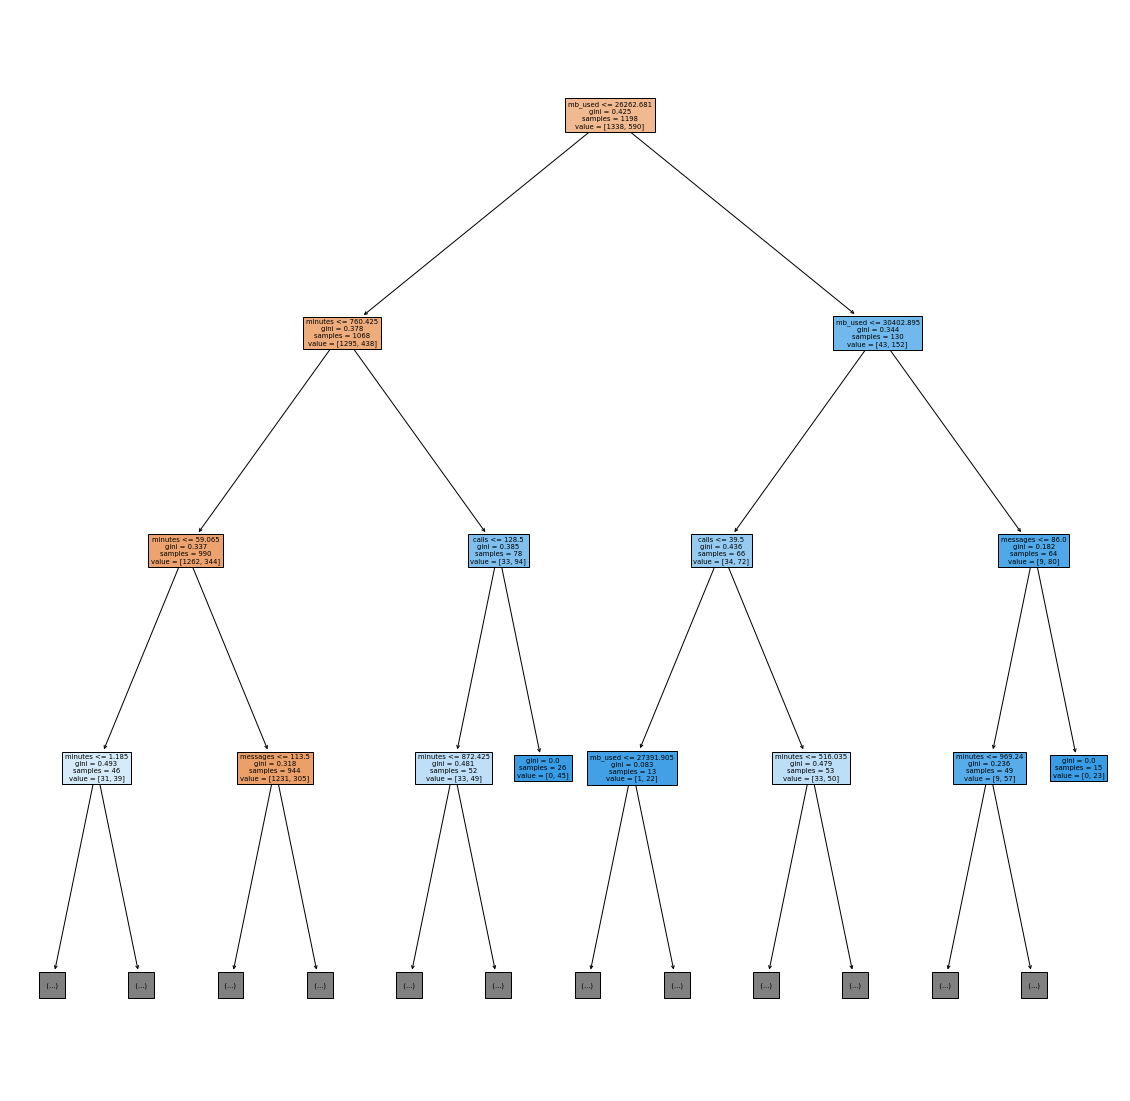

In [22]:
plt.figure(figsize=(20,20))
_ = tree.plot_tree(model_rf.estimators_[0], feature_names=features_train.columns, filled=True, max_depth = 3)

In [23]:
# Глубина первого дерева
model_rf.estimators_[0].tree_.max_depth

10

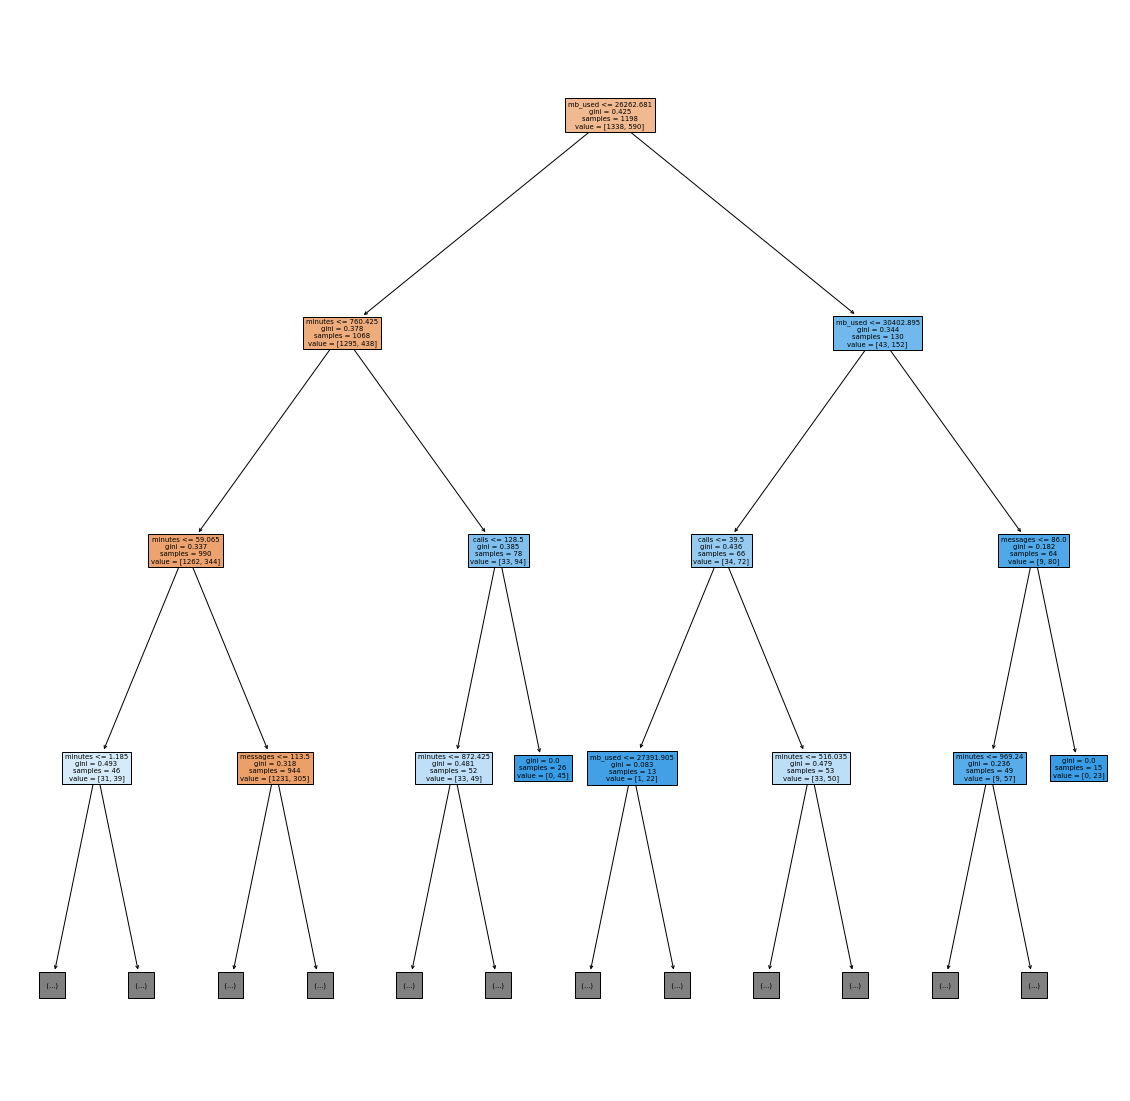

In [24]:
# Сюжет первого дерева решений:
plt.figure(figsize=(20,20))
_ = tree.plot_tree(model_rf.estimators_[0], feature_names=features_train.columns, filled=True, max_depth = 3)


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:
   


 
По большему числу гиперпараметров перебор -   тем лучше метрика. Случайный лес мощная модель и по ней действительно стоит поперебирать несколько гиперпораметров. Здорово   




<div class="alert alert-warning">


Совет: 




- Когда что то долго крутиться, можно использовать  %%time - ставишь на самый вверх ячейки с кодом, время выполнения которого хочешь замерить, может не знаешь.  Быстрее не станет, но все будут видеть стоит ли ждать не отходя от ПК или можно сходить чаек поставить )) 
    
    Или tqdm, это ещё лучше, потому что он показывает интерактивно, на каком этапе расчетов мы находимся

    
    from tqdm import tqdm


    for n_estimators in tqdm(range(3,58)):

        ..........



(дальше мы будем уходить от неэффективных в питоне циклов к apply.  Там тоже есть аналог прогресс-баров:  .progress_apply)
    
И будет красиво )   
 





</div>


<div style="background-color:lavender; padding:2%">
добавил прогрес-бары и график дерева
</div>

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>

Успех:

Отлично,  теперь заказчику можно обьяснить как примерно модель принимает решение. Только лучше это было сделать для дерево решение, ведь таких деревьев таких случайного леса сколько n_estimators. То есть plot_tree не так информативен тут, как был бы для DT

    

### Дерево решений

In [25]:
best_accuracy_df = 0
best_depth = 0
for depth in range(1,15):
    model = DecisionTreeClassifier(max_depth=depth, random_state=123456)
    model.fit(features_train, target_train)
    accuracy_df = model.score(features_valid, target_valid)
    if accuracy_df > best_accuracy_df:
        best_accuracy_df = accuracy_df
        best_depth = depth
print("Глубина дерева:", best_depth, "    Качество:", best_accuracy_df)

Глубина дерева: 5     Качество: 0.7978227060653188


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:
 
Работа выполнена в соответствии с критериями: 



 - модель обучена на обучающем наборе
 - получена оценка качества на валидационном наборе
 - перебор гиперпараметров осуществляется в цикле





<div class="alert alert-warning">


Совет: 



- Можно добавить график, хорошо оформленный график украсит проект. Тут на графике можно посмотреть как при изменении max_depth меняется точность на train и validation датасете (для этого собираем наши метрики на валидации и train в списки, а затем по ним обычный plt.plot()) Такой способ используют чтобы лучше отследить переобучение, но для этого стоит взять пернебор по max_depth поглубже


- tree_plot можно построить, с max_depth равной 3 или 4 (глубже уже будет громоздко) - глянуть как DT сплиты делает, будет понимание как модель принимает решения: какие признаки  использует, на каких значениях делает разбиение вправо - влево 




</div>



Сведем показатели точности (accuracy)

In [26]:
print(f"Logistic Regression: {accuracy_lr}")
print(f"Random Forest: {best_accuracy_rf}")
print(f"Decision Tree: {best_accuracy_df}")

Logistic Regression: 0.7402799377916018
Random Forest: 0.8180404354587869
Decision Tree: 0.7978227060653188


### Вывод 

Лучший показатель точности (accuracy) у Random Forest


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех:


Все верно, RF лучший. 


<div class="alert alert-warning">


Совет: 

Если есть желание можешь ответить на вопросики ))    



- Как назвать ситуацию, когда на валидации при увеличении глубины дерева (модель DT), метрика качества стала снижаться? Как по твоему в это же время вела себя эта же метрика на train?


- Насколько знаю вы еще под капот моделям не заглядывали, но может знаешь почему обычно RF показывает более высокие результаты из выбранных?


- Мы решаем задачу классификации (а еще есть задача регрессии), а в названии модели с помощью которой мы решаем задачу "классификации" (Логистическая регрессия) есть слово "регрессия".  Нет ли тут парадокса? )
    

- Почему логистическая регрессия показывать на много более худшие результаты?  


</div>





## Проверим модель на тестовой выборке

Используем "случайный лес" как самую точную

### Случайный лес

In [27]:
model = RandomForestClassifier(max_depth=7, n_estimators=35, min_samples_leaf=2, random_state=123456)
model.fit(features_train, target_train)

accuracy_rf_test = model.score(features_test, target_test)
print("Качество:", accuracy_rf_test)



Качество: 0.8133748055987559


Попробуем модель Random Forest обучить на тренировочной + валидационной выборке 

In [28]:
# Объединяем фичи
features_concat = pd.concat([features_train, features_valid], ignore_index=True)
features_concat.head()

,calls,minutes,messages,mb_used
0,73.0,620.25,0,21098.49
1,74.0,555.25,27,25718.19
2,36.0,206.01,1,14830.67
3,96.0,655.52,2,20432.78
4,40.0,225.89,12,13581.94


In [29]:
features_concat.shape

(2571, 4)

In [30]:
# Объединяем таргеты

target_concat = pd.concat([target_train, target_valid], ignore_index=True)
target_concat.head()

0    0
1    1
2    0
3    0
4    0
Name: is_ultra, dtype: int64

In [31]:
target_concat.shape

(2571,)

In [32]:
# Random Forest учим на тренировочной + валидационной выборке и проверяем на тестовой

In [33]:
model = RandomForestClassifier(max_depth=7, n_estimators=35, min_samples_leaf=2, random_state=123456)
model.fit(features_concat, target_concat)

accuracy_rf_test = model.score(features_test, target_test)
print("Качество:", accuracy_rf_test)

Качество: 0.8211508553654744


### Вывод 
Показатели модели Random Forest на тестовой выборке  0.813, что чуть ниже, чем на валидационной

Обучение на тренировочной + валидационной выборке улучшила точность модели Random Forest

## (бонус) Проверьте модели на адекватность

Используем DummyClassifier

Для проверки адекватности модели машинного обучения в Python, удобно использовать DummyClassifier из библиотеки scikit-learn. Это простой классификатор, который можно использовать в качестве эталонной модели.

Важно учитывать, что DummyClassifier не учитывает никаких особенностей данных и использует случайные значения для классификации, поэтому его результаты не могут быть использованы для принятия окончательных решений, а лишь для проверки адекватности моделей.

In [34]:
dmb = DummyClassifier(strategy="stratified", random_state=123456)
dmb.fit(features_train, target_train)
acc = dmb.score(features_test, target_test)
print("Качество наивного прогноза :", acc)


Качество наивного прогноза : 0.5987558320373251


In [35]:
dmb = DummyClassifier(strategy='most_frequent', random_state=123456)
dmb.fit(features_train, target_train)
acc = dmb.score(features_test, target_test)
print("Качество наивного прогноза :", acc)


Качество наивного прогноза : 0.7216174183514774


### Вывод 
Вывод. Наши показатели точности выше, чем у наивной модели

## Вывод

1. Были исследованы данные. Пропусков и дубликатов не обнаружено. Заменен тип значений у одной колонки

2. Данные были разбиты на 3 выборки: обучающая, валидационная выборка и тестовая выборка

3. Были исследованы три модели: логистическая регрессия, случайный лес, деревья решений. Лучший результат показала модель "случайный лес"

4. На тестовых данных были проверены эти же три модели. Наилучшее качество (0.81) показала модель "случайный лес" с гиперпараметрами 
`max_depth=7` , `_estimators=35` , `min_samples_leaf=2`
Обучение на тренировочной + валидационной выборке улучшила точность модели Random Forest

5. Была проведена проверка на адекватность. Модель адекватна